In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import math

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = resize(x_train, (x_train.shape[0], 32, 32, 1))
x_test = resize(x_test, (x_test.shape[0], 32, 32, 1))

# nx_train = np.zeros((x_train.shape[0], 64, 64, 1))
# nx_test = np.zeros((x_test.shape[0], 64, 64, 1))

# for i in range(len(nx_train)):
#     j = np.random.randint(0,3)
#     k = np.random.randint(0,3)
# #     j, k = 0, 0
#     x = (j*16, j*16+32)
#     y = (k*16, k*16+32)
#     nx_train[i][x[0]:x[1], y[0]:y[1]] = x_train[i]
    
# for i in range(len(nx_test)):
#     j = np.random.randint(0,3)
#     k = np.random.randint(0,3)
#     x = (j*16, j*16+32)
#     y = (k*16, k*16+32)
#     nx_test[i][x[0]:x[1], y[0]:y[1]] = x_test[i]

In [3]:
class BatchGenerator2(tf.keras.utils.Sequence):
    # Generate (x1,x2,x3,x4), x_tot for mini batches (x1-4 are quarters of x_tot)

    def __init__(self, x_set, batch_size):
        self.batch_size = batch_size
        self.xs = x_set
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.xs)/self.batch_size)

    def split(self, arr, nrows, ncols):
        r, h = arr.shape[:-1]
        return (arr.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols, 1)) 
    
    def embed(self, batch):
        imgs = np.zeros((self.batch_size, 64, 64, 1))
        locs = []
        for k in range(len(batch)):
            i, j = np.random.randint(0,3), np.random.randint(0,3)
            x, y = (i*16, i*16+32), (j*16, j*16+32)
            loc  = ((i+1)*16, (j+1)*16)
            imgs[k][x[0]:x[1], y[0]:y[1]] = batch[k]
            locs.append(loc)
        return imgs, locs

    def __getitem__(self, idx):
        batch = self.xs[idx*self.batch_size : (idx+1)*self.batch_size]
        imgs, locs = self.embed(batch)
        
        x1s, x2s, x3s, x4s = [], [], [], []
        #for x in batch:
        for x in imgs:
            #x1,x2,x3,x4 = self.split(x, 14, 14)
            x1,x2,x3,x4 = self.split(x, 32, 32) 
            x1s.append(x1)
            x2s.append(x2)
            x3s.append(x3)
            x4s.append(x4)
        xs = [np.array(x1s), np.array(x2s), np.array(x3s), np.array(x4s)]
        #return xs, batch
        return xs, imgs

    def on_epoch_end(self):
        self.xs = np.random.permutation(self.xs)

In [4]:
batch_size = 32
train_gen = BatchGenerator2(x_train, batch_size)
test_gen = BatchGenerator2(x_test, batch_size)

In [5]:
# model v1 with dense
input_shape = (32,32,1)
latent_dim = 4

# shared layers
conv1  = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(2,2), activation='relu', padding='valid', name='conv1')
conv2  = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='valid', name='conv2')
pt_conv = tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='sigmoid', padding='valid', name='pt_conv')
flat = tf.keras.layers.Flatten()
# dense1 = tf.keras.layers.Dense(units=4, name='separate_dense') # insert dense here: different setup.
dense1 = tf.keras.layers.Dense(units=16, name='separate_dense') # insert dense here: different setup.

# encoder
inputs = [tf.keras.layers.Input(shape=input_shape) for _ in range(4)]
outputs = []
for i in range(4):
    enc_out = dense1(flat(pt_conv(conv2(conv1(inputs[i])))))
    outputs.append(enc_out)
latent = tf.keras.layers.concatenate(outputs, name="concatenate")

# decoder
x = tf.keras.layers.Dense(units=4*8*8*32, activation='relu', name='dense')(latent)
x = tf.keras.layers.Reshape(target_shape=(2*8, 2*8, 32), name='reshape')(x)
x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
dec_out = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, padding='same')(x)

model1 = tf.keras.models.Model(inputs, dec_out)
model1.compile(loss='mse', optimizer='rmsprop')
print(model1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32, 32, 1)]  0                                            
______________________________________________________________________________________________

Epoch 1/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 2/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 3/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 4/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/20
1875/1875 [==============================] - 30s 16m

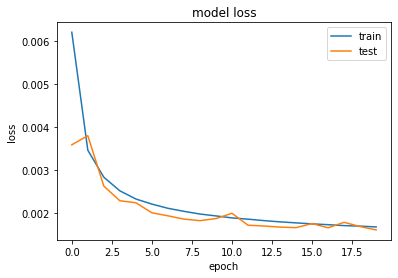

In [6]:
history = model1.fit(train_gen, validation_data=test_gen, epochs=20)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

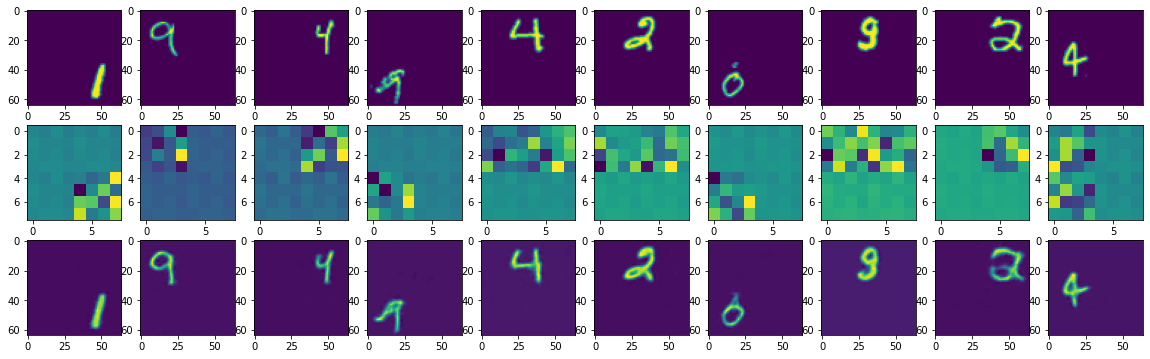

In [8]:
#activation_model = tf.keras.models.Model(inputs=model1.input, outputs=[model1.get_layer('pt_conv').output, model1.output])
activation_model = tf.keras.models.Model(inputs=model1.input, outputs=[model1.get_layer('concatenate').output, model1.output])

plt.figure(figsize=(20, 6))
n = 10
for (xs,ys),i in zip(test_gen, range(n)):
    out1, out = activation_model.predict(xs)
    ax = plt.subplot(3, n, i+1)
    plt.imshow(ys[i].reshape(64,64))
    
    ax = plt.subplot(3, n, n+i+1)  # plot the activation of fully connected layer per enc unit
#     plt.imshow(out1[i].reshape(8,8))
    latent_vec = out1[i]
    ls = [latent_vec[i*16:(i+1)*16].reshape(4,4) for i in range(4)]
    v1 = np.vstack((ls[0], ls[2]))
    v2 = np.vstack((ls[1], ls[3]))
    plt.imshow(np.hstack((v1, v2)))
    
    ax = plt.subplot(3, n, 2*n+i+1)
    plt.imshow(out[i].reshape(64,64))